In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import random

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

# import hyperparameters
from brnn_hyperparams import *
# from model import BRNN
from utils import load_dataset, get_num_class

import numpy as np

# processing bar
from tqdm import tqdm

# plots
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'{model_name}board_test')

### logging

In [2]:
import logging
logging.root.setLevel(logging.INFO)
# logging.basicConfig(level=logging.NOTSET)
logging.basicConfig(filename=log_name+'_test', 
                    filemode='a',
                    format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %P',
                    level=logging.INFO)

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.warning('Device: ' + device.type)
device

device(type='cuda')

In [4]:
batch_size = 4

## Utils

In [5]:
def load_dataset(fpath):
    '''
    params:
        fpath - path to fasta file, training or test
                ***The format of the sets:

                The first two lines are a global header:
                total_number_of_records
                input_size number_of_classes

                total_number_of_records is simply the number of proteins in the set,
                input_size is how many numbers are used to represent one amino acid (21
                or 22, probably, in your case) and number_of_classes is the number of
                classes...

                After that you have the proteins, 5 lines each:

                line 1: name of the protein
                line 2: number of amino acids in the protein
                line 3: input
                line 4: targets
                line 5: empty

                You can use any name you want so long as it's unique, a single word, and
                not outrageously long.

                The input should be a single long list of the numbers representing the
                amino acids in the protein. If you use, say, 21 numbers per amino acid,
                and the protein is 100 amino acids long, the input line will contain
                2100 numbers, with the first 21 being the representation of the first
                amino acid in the protein, the following 21 the representation of the
                second, etc.
                For the moment (before we use alignments) the representation of an amino
                acid will be a one-hot encoding, e.g.:

                A     -> 1 0 0 0 ..... 0 0
                C     -> 0 1 0 0 ..... 0 0
                ...
                Y     -> 0 0 0 0 ..... 1 0
                other -> 0 0 0 0 ..... 0 1

                where "other" is unknown or weird amino acid (X, B, J, O, U, Z)

                The line containing the targets is a list of integers representing the
                classes of the amino acids. There are as many integers as there are
                amino acids in the protein. You can choose whatever integers you want,
                but it's probably simplest to have something like class1=0, class2=1,
                class3=2, etc..

                (notice that in the sample sets in the directory you have a more
                complicated representation of the inputs, where there are a lot of
                floating point numbers rather than just 0 and 1, and that's because
                those inputs are frequency profiles from MSA - so you can see how the
                code works for both kinds of inputs)
                
    returns:
        p_data - list[data_tensor, target_tensor]
        p_lens - list, protein length
    
    Note: 
        - the reason not using tensor to save protein Sequences and Targets is we have varying length sequences! 
        - solve this problem we could consider pading. But our dataset lens range from about 20 to 10,000. 
            Thus, padding maybe not a good idea here.
        - to solve variance sequences problem, we can use pad_sequence, pack_padded_sequence & 
    '''
    num_protein = 0
    num_i = 0
    num_o = 0

    # p_names = []
    p_lens = []
    # p_seqs = []
    # p_anns = []
    p_data = []
    with open(fpath) as fp:
        num_protein = int(fp.readline())
        num_io = fp.readline().split(' ')
        num_i = int(num_io[0])
        num_o = int(num_io[0])

        line = fp.readline()
        while line:
            # p_name = line[:-1]
            p_len = int(fp.readline())
            p_sequence = torch.tensor([int(x) for x in fp.readline().split(' ')], 
                                      dtype=torch.float32).reshape(-1, 21)
            p_annotation = torch.tensor([[int(x)] for x in fp.readline().split(' ')], dtype=torch.float32)
            # skip empty
            next(fp)
            # p_names.append(p_name)
            p_lens.append(p_len)
            # p_seqs.append(p_sequence)
            # p_anns.append(p_annotation)
            p_data.append([p_sequence, p_annotation])
            line = fp.readline()   
    return p_data, p_lens


In [7]:
class ProteinDataset(Dataset):
    
    def __init__(self, fpath, transform=None):
        self.p_data, self.p_lens = load_dataset(fpath)
    
    def __len__(self) -> int:
        return len(self.p_lens)
    
    def __getitem__(self, i) -> torch.Tensor:
        # self.p_data[i][0], sequence;  self.p_data[i][1], label
        return self.p_data[i][0], self.p_data[i][1]
    def numAAs(self) -> int:
        return sum(self.p_lens)

In [34]:
def pad_packed_collate(batch):
    """Puts data, and lengths into a packed_padded_sequence then returns
       the packed_padded_sequence and the labels. Set use_lengths to True
       to use this collate function.
       Args:
         batch: (list of tuples) [(sequence, target)].
             sequence is a FloatTensor
             target has the same variable length with sequence
       Output:
         packed_batch: (PackedSequence), see torch.nn.utils.rnn.pack_padded_sequence
         labels: (Tensor), labels from the file names of the wav.
    """

    if len(batch) == 1:
        seqs, labels = [batch[0][0]], [batch[0][1]]
        lengths = [seqs[0].size(0)]
        
    if len(batch) > 1:
        # get data and sorted by the length of sequence
        seqs, labels, lengths = zip(*[(a, b, a.size(0)) for (a,b) in sorted(batch, key=lambda x: x[0].size(0), reverse=True)])
    seqs = pad_sequence(seqs, batch_first=True)
    labels = pad_sequence(labels, batch_first=True)
    packed_seqs = pack_padded_sequence(seqs, lengths, batch_first=True)
    packed_labels = pack_padded_sequence(labels, lengths, batch_first=True)
    
    return packed_seqs, packed_labels


In [9]:
def pad_packed_collate_manuals(batch):
    """Puts data, and lengths into a packed_padded_sequence then returns
       the packed_padded_sequence and the labels. Set use_lengths to True
       to use this collate function.
       Args:
         batch: (list of tuples) [(audio, target)].
             audio is a FloatTensor
             target is a LongTensor with a length of 8
       Output:
         packed_batch: (PackedSequence), see torch.nn.utils.rnn.pack_padded_sequence
         labels: (Tensor), labels from the file names of the wav.
    """

    if len(batch) == 1:
        seqs, labels = batch[0][0], batch[0][1]
        lengths = [seqs.size(0)]
        seqs.unsqueeze_(0)
        labels.unsqueeze_(0)
    if len(batch) > 1:
        # get data and sorted by the length of sequence
        seqs, labels, lengths = zip(*[(a, b, a.size(0)) for (a,b) in sorted(batch, key=lambda x: x[0].size(0), reverse=True)])
        max_len, n_feats = seqs[0].size()
        # padding sequence with zeros
        seqs = [torch.cat((s, torch.zeros(max_len - s.size(0), n_feats)), 0) if s.size(0) != max_len else s for s in seqs]
        seqs = torch.stack(seqs, 0)
        #labels = torch.stack(labels, 0)
    packed_batch = pack(seqs, lengths, batch_first=True)
    return packed_batch


In [10]:
def get_num_class(input_data):
    '''
    params:
        input_data - p_data format return from load_dataset function.
        
    returns:
        c0 - the number of amino acids of class 0, which means ordered.
        c1 - the number of amino acids of class 1, which means disordered.
    '''
    c0 = 0
    c1 = 0
    for batch_idx, (data, target) in enumerate(input_data):
        c0 = c0 + len(target) - target.sum()
        c1 = c1 + target.sum()
    return c0, c1


In [11]:
def rocPlot(train_label, train_probs, val_label, val_probs):
    fig = plt.figure(figsize=(12, 6))
    fpr, tpr, thresholds = roc_curve(train_label, train_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Training")
    plt.legend(loc="lower right")

    fpr, tpr, thresholds = roc_curve(val_label, val_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Validation")
    plt.legend(loc="lower right")
    plt.show()
    return fig

## Dataset

In [12]:
# !!!!
# file need extra one empty line
# !!!!
logging.warning('Loading training file ...')
train_ds = ProteinDataset(train_fpath)
logging.warning('Loading test file ...')
test_ds = ProteinDataset(test_fpath)

In [13]:
train_ds.p_data[0][1].size()

torch.Size([640, 1])

In [35]:
# dataloader
# using pad_packed_collate to deal with padding
train_dl = DataLoader(train_ds, batch_size = batch_size, num_workers = 72, shuffle=True, collate_fn=pad_packed_collate)
test_dl = DataLoader(test_ds, batch_size = batch_size, num_workers = 72, shuffle=False, collate_fn=pad_packed_collate)


In [115]:
logging.warning('Training set: ' + str(len(train_ds.p_lens)))
logging.warning('Test set:     ' + str(len(test_ds.p_lens)))

In [72]:
# for batch_idx, (data, label) in enumerate(train_dl):
#     print(data.batch_sizes[0])

In [45]:
data.batch_sizes[0]

tensor(1)

In [28]:
batch_idx

1030

In [29]:
test_ds.p_data[1030][0].size()

torch.Size([208, 21])

## Model

In [48]:
# set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropP = 0.5):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                         bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(p = dropP)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.batch_sizes[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.batch_sizes[0], self.hidden_size).to(device)
        # Forward Prop
        # out, (hn, cn) = self.lstm(x,  (h0, c0))
        # out, _ = self.lstm(x,  (h0, c0))
        packed_out, (hn, cn) = self.lstm(x,  (h0, c0))
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # all training example, last hidden state, all 
        # it is not last hidden state, it is the last batch
        # print('out.squeeze() ', out.squeeze().size())
        out = self.fc(out)
        out = self.drop(out)
        out = self.sigmoid(out)
        return out
    
    def train_batch(self, train_loader, optimizer, criterion):
        # set training state to model
        self.to(device)
        self.train()
        
        with tqdm(total=len(train_loader), position=0) as progress_bar:
            for batch_idx, (data, label) in enumerate(train_loader):
                data = data.to(device)
                label = label.to(device)
                optimizer.zero_grad()
                output = self(data)
                label, _ = pad_packed_sequence(label, batch_first=True)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
                progress_bar.update(1)
                
    def val_batch(self, val_data, criterion): 
        # set evaluation state to the model
        self.to(device)
        self.eval()
        losses = []
        
        class_probs = []
        class_label = []
        
        # no gradient needed
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_data):
                data = data.to(device)
                target = target.to(device)
                # forward
                scores = self(data)
                target, _ = pad_packed_sequence(target, batch_first=True)
                loss = criterion(scores, target)
                # ERROR
                losses.append(loss.cpu()) # loss for each batch
                # save for ploting curve
                class_probs.append(scores.squeeze(-1).cpu())
                class_label.append(target.cpu())
                
        # overall loss
        loss = np.mean(losses)
        return loss, class_probs, class_label

## Initialization

In [49]:
# init model
model = BRNN(input_size, hidden_size, num_layers, num_classes)
# propogation of two classes

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

 86%|█████████████████████████████████████████████████████▏        | 886/1032 [01:53<00:13, 10.51it/s]

[219]


100%|█████████████████████████████████████████████████████████████| 1032/1032 [02:09<00:00,  7.95it/s]


[366]
[258]
Training: Loss:
0.2372047
VAL: Loss:
0.23558748


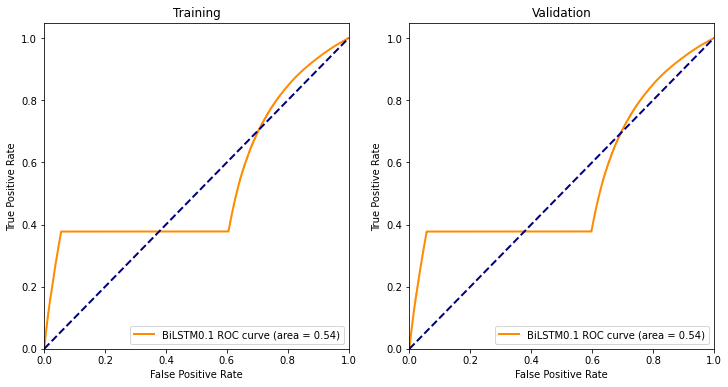

  0%|                                                                        | 0/1032 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2b3300f80>
Traceback (most recent call last):
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _ConnectionBase.__del__ at 0x7fa2b3637dd0>
Traceback (most recent call last):
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/home/qinqin/anaconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/qinqin/anacon

[225]


100%|█████████████████████████████████████████████████████████████| 1032/1032 [02:14<00:00,  7.69it/s]


[509]
[258]
Training: Loss:
0.20530608
VAL: Loss:
0.20381492


In [77]:
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate}")

num_epochs = 2

for epoch in range(num_epochs):
    logging.warning('*********************************')
    logging.warning('epoch: ' + str(epoch))
    logging.warning('*********************************')
    ################
    # 3.1. Training
    ################
    logging.warning('1. TRAINING:')
    # plot pr and roc curve or not
    plot_pr_roc = (epoch % plot_nEpoch == 0)

    # training
    model.train_batch(train_dl, optimizer, criterion)
    
    # acc & loss
    train_loss, t_class_probs, t_class_label = model.val_batch(train_dl, criterion)
    val_loss, v_class_probs, v_class_label = model.val_batch(test_dl, criterion)
    
    # val_accs.append(val_acc)
    
    print('Training: Loss:')
    print(train_loss)
    
    print('VAL: Loss:')
    print(val_loss)
    
    logging.warning('Training:')
    logging.warning(f'Loss: {train_loss}')

    logging.warning('Validation:')
    logging.warning(f'Loss: {val_loss}')
    
    ##
    # for tensorboard plots
    ##
    writer.add_scalar("TRAIN: loss", train_loss, epoch)
    #writer.add_scalar("TRAIN: acc", train_acc, epoch)
    
    writer.add_scalar("VAL: loss", val_loss, epoch)
    #writer.add_scalar("VAL: acc", val_acc, epoch)
    
    ##
    # PR-curve & ROC-curve
    ##
    if plot_pr_roc:
        train_probs = torch.cat([batch.reshape(-1) for batch in t_class_probs])
        train_label = torch.cat([lab.reshape(-1) for lab in t_class_label])

        writer.add_pr_curve(f'TRAIN: pr_curve e{epoch}', train_label, train_probs, 0)

        val_probs = torch.cat([batch.reshape(-1) for batch in v_class_probs])
        val_label = torch.cat([lab.reshape(-1) for lab in v_class_label])

        writer.add_pr_curve(f'VAL: pr_curve e{epoch}', val_label, val_probs, 0)

        roc_fig = rocPlot(train_label, train_probs, val_label, val_probs)
        writer.add_figure(f'Train vs VAL: roc_curve e{epoch}', roc_fig)
    ##
    # Save model every m epochs
    ##
    if epoch % checkpoint_m == 0:
        cPATH = f"checkpoint/{model_name}_{epoch}.pth"
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_loss,
                    }, cPATH)
        
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                 num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate} \n ")
                # best_val_epoch: {int(np.argmax(val_accs)+1)}") # the best val epoch

writer.flush()
writer.close()

In [74]:
torch.cat([batch.reshape(-1) for batch in t_class_probs]).size()

torch.Size([4308820])

In [76]:
torch.cat([batch.reshape(-1) for batch in t_class_label]).size()

torch.Size([4308820])

In [62]:
a = torch.tensor([[1, 2], [3, 4], [5, 6], [7, 8]])
a

tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])

In [67]:
a.reshape(-1).shape

torch.Size([8])

In [ ]:
from torchinfo import summary

seq_len = 2000
summary(model, input_size=(1, seq_len, 21))

In [65]:
print(model)

BRNN(
  (lstm): LSTM(21, 24, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [51]:
from torchinfo import summary

seq_len = 2000
summary(model, input_size=(1, seq_len, 21))

h0:  torch.Size([4, 1, 24])
c0:  torch.Size([4, 1, 24])
out:  torch.Size([1, 2000, 48])
hn:  torch.Size([4, 1, 24])
cn:  torch.Size([4, 1, 24])
out.squeeze()  torch.Size([2000, 48])
out final:  torch.Size([2000, 1])


Layer (type:depth-idx)                   Output Shape              Param #
BRNN                                     [2000, 1]                 --
├─LSTM: 1-1                              [1, 2000, 48]             23,232
├─Linear: 1-2                            [2000, 1]                 49
├─Sigmoid: 1-3                           [2000, 1]                 --
Total params: 23,281
Trainable params: 23,281
Non-trainable params: 0
Total mult-adds (M): 46.56
Input size (MB): 0.17
Forward/backward pass size (MB): 0.78
Params size (MB): 0.09
Estimated Total Size (MB): 1.05

## Test pad_sequence & pack_padded_sequence & pad_packed_sequence
### 1. pad_sequence

In [79]:
a = [torch.tensor([[1,2,3], [2,3,4], [4,5,6]]), torch.tensor([[3,4, 5]])]
a_pad = torch.nn.utils.rnn.pad_sequence(a, batch_first=True)

b = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b_pad = torch.nn.utils.rnn.pad_sequence(b, batch_first=True)

In [80]:
a

[tensor([[1, 2, 3],
         [2, 3, 4],
         [4, 5, 6]]),
 tensor([[3, 4, 5]])]

In [81]:
a_pad

tensor([[[1, 2, 3],
         [2, 3, 4],
         [4, 5, 6]],

        [[3, 4, 5],
         [0, 0, 0],
         [0, 0, 0]]])

In [82]:
b

[tensor([1, 2, 3]), tensor([3, 4])]

In [83]:
b_pad

tensor([[1, 2, 3],
        [3, 4, 0]])

### pack_padded_sequence

In [84]:
a_pack = torch.nn.utils.rnn.pack_padded_sequence(a_pad, batch_first=True, lengths=[3,1])
a_pack

PackedSequence(data=tensor([[1, 2, 3],
        [3, 4, 5],
        [2, 3, 4],
        [4, 5, 6]]), batch_sizes=tensor([2, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [85]:
b_pack = torch.nn.utils.rnn.pack_padded_sequence(b_pad, batch_first=True, lengths=[3,2])
b_pack

PackedSequence(data=tensor([1, 3, 2, 4, 3]), batch_sizes=tensor([2, 2, 1]), sorted_indices=None, unsorted_indices=None)

### pad_packed_sequence

In [86]:
a_reverse_pack = torch.nn.utils.rnn.pad_packed_sequence(a_pack, batch_first=True)
a_pad, a_reverse_pack


(tensor([[[1, 2, 3],
          [2, 3, 4],
          [4, 5, 6]],
 
         [[3, 4, 5],
          [0, 0, 0],
          [0, 0, 0]]]),
 (tensor([[[1, 2, 3],
           [2, 3, 4],
           [4, 5, 6]],
  
          [[3, 4, 5],
           [0, 0, 0],
           [0, 0, 0]]]),
  tensor([3, 1])))

In [87]:
b_reverse_pack = torch.nn.utils.rnn.pad_packed_sequence(b_pack, batch_first=True)
b_pad, b_reverse_pack

(tensor([[1, 2, 3],
         [3, 4, 0]]),
 (tensor([[1, 2, 3],
          [3, 4, 0]]),
  tensor([3, 2])))

## Note
### 1. pad_sequence does not sort sequence by seq_len

In [88]:
from torch.nn.utils.rnn import pad_sequence
c = [torch.ones(5, 10), torch.ones(7, 10), torch.ones(3, 10)]
c_pad = pad_sequence(c, batch_first=True)
c_pad

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0

### 2. but pack_padded_sequence wants a sorted pad_result

In [89]:
c_pack = torch.nn.utils.rnn.pack_padded_sequence(c_pad, batch_first=True, lengths=[5,7,3])
c_pack

RuntimeError: `lengths` array must be sorted in decreasing order when `enforce_sorted` is True. You can pass `enforce_sorted=False` to pack_padded_sequence and/or pack_sequence to sidestep this requirement if you do not need ONNX exportability.

### 3. set enforce_sorted=False or padding manuly

In [95]:
c_pack = torch.nn.utils.rnn.pack_padded_sequence(c_pad, batch_first=True, lengths=[5,7,3], enforce_sorted=False)
c_pack


PackedSequence(data=tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), batch_sizes=tensor([3, 3, 3, 2, 2, 1, 1]), sorted_indices=tensor([1, 0, 2]), unsorted_indices=tensor([1, 0, 2]))

### 4. sorted_indices & unsorted_indices are not none only if enforce_sorted=False